# Data description: 
I'm going to solve the International Airline Passengers prediction problem. This is a problem where given a year and a month, the task is to predict the number of international airline passengers in units of 1,000. The data ranges from January 1949 to December 1960 or 12 years, with 144 observations.

# Workflow:
- Load the Time Series (TS) by Pandas Library
- Prepare the data, i.e. convert the problem to a supervised ML problem
- Build and evaluate the RNN model: 
     - Fit the best RNN model
     - Evaluate model by in-sample prediction: Calculate RMSE
- Forecast the future trend: Out-of-sample prediction

Note: For data exploration of this TS, please refer to the notebook of my alternative solution with "Seasonal ARIMA model"

In [1]:
import keras
import sklearn
import tensorflow as tf
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
import random as rn
import math
%matplotlib inline

from keras import backend as K
session_conf = tf.ConfigProto(intra_op_parallelism_threads=5, inter_op_parallelism_threads=5)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Load data using Series.from_csv
from pandas import Series
#TS = Series.from_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/daily-minimum-temperatures.csv', header=0)

# Load data using pandas.read_csv
# in case, specify your own date parsing function and use the date_parser argument
from pandas import read_csv
TS = read_csv('C:/Users/rhash/Documents/Datasets/Time Series analysis/AirPassengers.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

print(TS.head())

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64


In [3]:
#TS=pd.to_numeric(TS, errors='coerce')
TS.dropna(inplace=True)
data=pd.DataFrame(TS.values)

In [4]:
# prepare the data (i.e. convert problem to a supervised ML problem)
def prepare_data(data, lags=1):
    """
    Create lagged data from an input time series
    """
    X, y = [], []
    for row in range(len(data) - lags - 1):
        a = data[row:(row + lags), 0]
        X.append(a)
        y.append(data[row + lags, 0])
    return np.array(X), np.array(y)

In [5]:
# normalize the dataset
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)
 
# split into train and test sets
train = dataset[0:120, :]
test = dataset[120:, :]

In [6]:
# LSTM RNN model: _________________________________________________________________
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Dropout, average, Input, merge, concatenate
from keras.layers.merge import concatenate
from keras.regularizers import l2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_sample_weight
from keras.layers.normalization import BatchNormalization


# reshape into X=t and Y=t+1
lags = 3
X_train, y_train = prepare_data(train, lags)
X_test, y_test = prepare_data(test, lags)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], lags, 1))
X_test = np.reshape(X_test, (X_test.shape[0], lags, 1))

# create and fit the LSTM network
mdl = Sequential()
#mdl.add(Dense(3, input_shape=(1, lags), activation='relu'))
mdl.add(LSTM(4, activation='relu'))
#mdl.add(Dropout(0.1))
mdl.add(Dense(1))

mdl.compile(loss='mean_squared_error', optimizer='adam')
monitor=EarlyStopping(monitor='loss', min_delta=0.001, patience=100, verbose=1, mode='auto')
history=mdl.fit(X_train, y_train, epochs=1000, batch_size=1, validation_data=(X_test, y_test), callbacks=[monitor], verbose=0)


# To measure RMSE and evaluate the RNN model:
from sklearn.metrics import mean_squared_error

# make predictions
train_predict = mdl.predict(X_train)
test_predict = mdl.predict(X_test)
 
# invert transformation
train_predict = scaler.inverse_transform(pd.DataFrame(train_predict))
y_train = scaler.inverse_transform(pd.DataFrame(y_train))
test_predict = scaler.inverse_transform(pd.DataFrame(test_predict))
y_test = scaler.inverse_transform(pd.DataFrame(y_test))
 
# calculate root mean squared error
train_score = math.sqrt(mean_squared_error(y_train, train_predict[:,0]))
print('Train Score: {:.2f} RMSE'.format(train_score))
test_score = math.sqrt(mean_squared_error(y_test, test_predict[:,0]))
print('Test Score: {:.2f} RMSE'.format(test_score))

Epoch 00161: early stopping
Train Score: 27.08 RMSE
Test Score: 57.58 RMSE


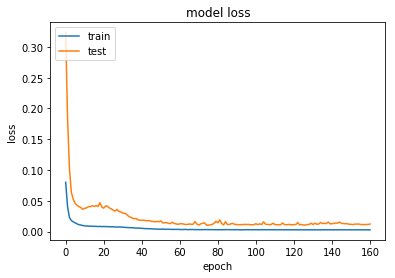

In [7]:
# list all data in history
#print(history.history.keys())

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
mdl.save('passenger_model.h5')

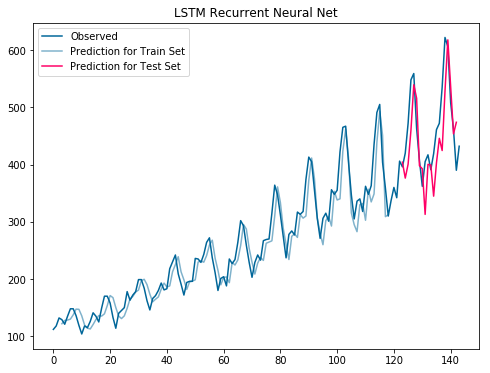

In [9]:
# shift train predictions for plotting
train_predict_plot =np.full(data.shape, np.nan)
train_predict_plot[lags:len(train_predict)+lags, :] = train_predict
 
# shift test predictions for plotting
test_predict_plot =np.full(data.shape, np.nan)
test_predict_plot[len(train_predict) + (lags * 2)+1:len(data)-1, :] = test_predict
 
# plot observation and predictions
plt.figure(figsize=(8,6))
plt.plot(data, label='Observed', color='#006699');
plt.plot(train_predict_plot, label='Prediction for Train Set', color='#006699', alpha=0.5);
plt.plot(test_predict_plot, label='Prediction for Test Set', color='#ff0066');
plt.legend(loc='upper left')

plt.title('LSTM Recurrent Neural Net')
plt.show()

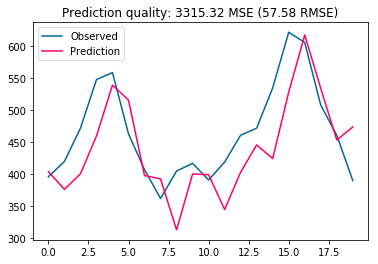

In [10]:
mse = mean_squared_error(y_test, test_predict[:,0])
plt.title('Prediction quality: {:.2f} MSE ({:.2f} RMSE)'.format(mse, math.sqrt(mse)))
plt.plot(y_test.reshape(-1, 1), label='Observed', color='#006699')
plt.plot(test_predict.reshape(-1, 1), label='Prediction', color='#ff0066')
plt.legend(loc='upper left');

plt.show()